In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from tqdm import tqdm
from joblib import dump, load
import pickle
from sklearn.metrics import *
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_path = '../prediction_data/'

In [3]:
# read in population dataframe
num_days_prediction = 90
df_pop = pd.read_csv(data_path+"population.csv")
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="%Y-%m-%d")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

In [4]:
# table 1
all_race = df_pop.groupby('race_concept_id').count()['cohort_definition_id']
scz_race = df_pop.loc[df_pop['sz_flag']==1].groupby('race_concept_id').count()['cohort_definition_id']
noscz_race = df_pop.loc[df_pop['sz_flag']==0].groupby('race_concept_id').count()['cohort_definition_id']
race_counts = pd.DataFrame(pd.concat([all_race, scz_race, noscz_race], axis=1).values, 
             index=['Missing', 'Black or African American', 'White'], columns = ['All Patients', 'SCZ Patients', 'No SCZ Patients'])

all_gender = df_pop.groupby('gender_concept_id').count()['cohort_definition_id']
scz_gender = df_pop.loc[df_pop['sz_flag']==1].groupby('gender_concept_id').count()['cohort_definition_id']
noscz_gender = df_pop.loc[df_pop['sz_flag']==0].groupby('gender_concept_id').count()['cohort_definition_id']
gender_counts = pd.DataFrame(pd.concat([all_gender, scz_gender, noscz_gender], axis=1).values, 
             index=['Male', 'Female'], columns = ['All Patients', 'SCZ Patients', 'No SCZ Patients'])

age = pd.DataFrame(df_pop.groupby('sz_flag')['age_diagnosis'].agg(['mean','std']).values, index=['SCZ Patients', 'No SCZ Patients'],
            columns = ['Mean Age', 'STD Age']).T
age['All Patients'] = df_pop['age_diagnosis'].mean(), df_pop['age_diagnosis'].std()

t1_counts = pd.concat([race_counts, gender_counts, age])
t1_counts.loc['Total Patients'] = len(df_pop), sum(df_pop['sz_flag']), len(df_pop)-sum(df_pop['sz_flag'])
t1_counts

t1_percents = t1_counts.loc[['Missing', 'Black or African American', 'White', 'Male','Female']]
t1_percents = t1_percents/t1_counts.loc['Total Patients']*100
t1_percents

,All Patients,SCZ Patients,No SCZ Patients
Missing,16.143139,20.749782,15.909693
Black or African American,28.325134,29.293810,28.276045
White,55.531727,49.956408,55.814262
Male,48.946638,52.048823,48.789432
Female,51.053362,47.951177,51.210568


In [5]:
# table 1: years of observation prior to psychosis
all_visits = pd.read_csv(data_path+'temporal_visits.csv')
df_pop = df_pop.merge(all_visits.groupby('person_id').min()['visit_start_date'], how='left', left_on='person_id',right_index=True)
df_pop.rename({'visit_start_date':'first_visit'}, axis=1, inplace=True)

In [6]:
df_pop['first_visit'] = pd.to_datetime(df_pop['first_visit'])
df_pop['years_obs_pre_psychosis'] = (df_pop['psychosis_diagnosis_date']-df_pop['first_visit']).dt.days/365

In [7]:
df_pop.loc[df_pop['sz_flag']==1, 'years_obs_pre_psychosis'].mean(), df_pop.loc[df_pop['sz_flag']==1, 'years_obs_pre_psychosis'].std()

(4.531069735223514, 2.582191386774663)

In [8]:
# table 1: years of observation between psychosis and index (end of obs) 
df_pop['years_obs_post_psychosis'] = (df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days/365

In [9]:
df_pop.loc[df_pop['sz_flag']==0, 'years_obs_post_psychosis'].mean(), df_pop.loc[df_pop['sz_flag']==0, 'years_obs_post_psychosis'].std()

(4.11269383797681, 2.4711586167600625)

In [10]:
# table 1: number of visits in the dataset (between psychosis and censor)
all_visits = all_visits.loc[all_visits['person_id'].isin(df_pop['person_id'])]
all_visits['cohort_start_date'] = pd.to_datetime(all_visits['cohort_start_date'])
all_visits['visit_start_date'] = pd.to_datetime(all_visits['visit_start_date'])
all_visits['visit_end_date'] = pd.to_datetime(all_visits['visit_end_date'])
all_visits = all_visits.loc[(all_visits['cohort_start_date']-all_visits['visit_end_date']).dt.days >= num_days_prediction]
all_visits = all_visits.loc[all_visits['visit_start_date'] >= all_visits['psychosis_diagnosis_date']]
all_visits = all_visits[['person_id', 'cohort_start_date', 'visit_start_date']].drop_duplicates()

num_visits = all_visits.groupby('person_id').count()['cohort_start_date']
num_visits.name = 'number_of_visits'
df_pop = df_pop.merge(pd.DataFrame(num_visits), how = 'inner', left_on = 'person_id', right_index=True)
df_pop['number_of_visits'].mean()

210.81933799376736

In [11]:
df_pop.loc[df_pop['sz_flag']<=1, 'number_of_visits'].mean(), df_pop.loc[df_pop['sz_flag']<=1, 'number_of_visits'].std()

(210.81933799376736, 346.3302476363843)

In [12]:
# Fisher Exact Tests to compare proportion of genders, races
# table looks like [[scz_demo, scz_non-demo], [non-scz_demo, non-scz_non-demo]]
demos = ['race_concept_id', 'race_concept_id', 'race_concept_id', 'gender_concept_id', 'gender_concept_id']
c_ids = [8516, 8527, 0, 8532, 8507]
for demo, c_id in zip(demos, c_ids):
    scz_demo = len(df_pop.loc[(df_pop['sz_flag']==1)&(df_pop[demo]==c_id)])
    scz_nodemo = len(df_pop.loc[(df_pop['sz_flag']==1)&(df_pop[demo]!=c_id)])
    noscz_demo = len(df_pop.loc[(df_pop['sz_flag']==0)&(df_pop[demo]==c_id)])
    noscz_nodemo = len(df_pop.loc[(df_pop['sz_flag']==0)&(df_pop[demo]!=c_id)])
    arr = np.asarray([[scz_demo, scz_nodemo], [noscz_demo, noscz_nodemo]])
    print(c_id, stats.fisher_exact(arr).pvalue*5)

8516 2.296590024210506
8527 0.0005977305230801415
0 0.00012822723688242873
8532 0.14493400520947344
8507 0.14493400520947344


In [13]:
# t-tests to compare continuous variables
for feature in ['age_diagnosis', 'years_obs_pre_psychosis', 'number_of_visits', 'years_obs_post_psychosis']:
    print(feature)
    scz_subset = df_pop.loc[df_pop['sz_flag']==1, feature]
    noscz_subset = df_pop.loc[df_pop['sz_flag']==0, feature]
    print(stats.ttest_ind(scz_subset, noscz_subset).pvalue*5)

age_diagnosis
1.6562577033202295e-17
years_obs_pre_psychosis
0.028098733337589533
number_of_visits
6.466589602906364e-10
years_obs_post_psychosis
1.6434047217876397e-07


In [14]:
# read in population dataframe
num_days_prediction = 90
df_pop = pd.read_csv(data_path+"population.csv")
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="%Y-%m-%d")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

# load test data for evaluation
train_test_split = pd.read_csv('stored_data/patient_split_4_19.csv')
test_labels = pd.read_csv('stored_data/4_19_model_test_output.csv')
df_iter_pop = pd.read_csv('stored_data/iterated_population_8_visits.csv')

test_labels = test_labels.merge(df_pop[['person_id', 'race_concept_id', 'gender_concept_id']], how='left',
                 left_on='person_id', right_on='person_id')

test_labels = test_labels.merge(df_iter_pop[['person_id', 'iteration', 'psychosis_diagnosis_date', 'cutoff_date', 'censor_date']], how='inner', left_on = ['person_id', 'iteration'], right_on=['person_id', 'iteration'])

In [15]:
print('Accuracy', (test_labels['sz_flag'] == test_labels['y_pred']).sum()/len(test_labels))
tn, fp, fn, tp = confusion_matrix(test_labels['sz_flag'], test_labels['y_pred']).ravel()
print('Sensitivity', (tp/(tp+fn)))
print('Specificity', (tn/(tn+fp)))
print('AUPRC', average_precision_score(test_labels['sz_flag'], test_labels['prob_1']))
print('PPV', precision_score(test_labels['sz_flag'], test_labels['y_pred']))
print('AUROC', roc_auc_score(test_labels['sz_flag'], test_labels['prob_1']))

Accuracy 0.9736546553196874
Sensitivity 0.9696485623003195
Specificity 0.9739302439601684
AUPRC 0.9705026334541258
PPV 0.718997722095672
AUROC 0.9967593570869699


In [16]:
# table 2: model performance
def get_ci(y_test, y_pred, pred_prob, threshold=0.95):
    """
    gives us 95% CI for auroc, auprc
    """
    rng = np.random.RandomState(seed=44)
    idx = np.arange(y_test.shape[0])

    test_auroc = []
    test_auprc = []
    for i in range(300):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        if len(set(y_test.iloc[pred_idx])) > 1:
            test_auroc.append(roc_auc_score(y_test.iloc[pred_idx], pred_prob.iloc[pred_idx]))
            test_auprc.append(average_precision_score(y_test.iloc[pred_idx], pred_prob.iloc[pred_idx]))
            
    auroc_interval = (np.percentile(test_auroc, 2.5), np.percentile(test_auroc, 97.5))
    auprc_interval = (np.percentile(test_auprc, 2.5), np.percentile(test_auprc, 97.5))
    
    return auroc_interval, auprc_interval

def results_per_iter(test_value_subset, iterations_name):
    iterations = test_value_subset[iterations_name].unique()
    iterations.sort()
    auroc = []
    auroc_ci = []
    auprc = []
    auprc_ci = []

    num_patients = []
    frac_pos_samples = []
    num_visits = []
    num_visits_ci = []
    for i in iterations:
        df_subset = test_value_subset.loc[test_value_subset[iterations_name]==i]
        if len(df_subset['sz_flag'].unique()) > 1:
            auroc_val = roc_auc_score(df_subset['sz_flag'], df_subset['prob_1'])
            auroc.append(auroc_val)
            
            auprc_val = average_precision_score(df_subset['sz_flag'], df_subset['prob_1'])
            auprc.append(auprc_val)
            
            confidence_intervals = get_ci(df_subset['sz_flag'], df_subset['y_pred'], df_subset['prob_1'])
            auroc_ci.append(confidence_intervals[0])
            auprc_ci.append(confidence_intervals[1])
        else:
            print('iteration',i, 'has only one class')
            auroc.append(np.nan)
            auroc_ci.append((np.nan, np.nan))
            auprc.append(np.nan)
            auprc_ci.append((np.nan, np.nan))
            

        num_patients.append(len(df_subset))
        frac_pos_samples.append(sum(df_subset['sz_flag'])/len(df_subset))
        num_visits.append(np.mean(df_subset['iteration']*10))
        num_visits_ci.append(stats.sem(df_subset['iteration']*10) * stats.t.ppf((1 + 0.95) / 2., len(df_subset)-1))
        
    return auroc, auroc_ci, auprc, auprc_ci, num_patients, frac_pos_samples, num_visits, num_visits_ci

def get_ci_all_table(y_test, y_pred, pred_prob, threshold=0.95):
    """
    gives us 95% CI for auroc, auprc
    """
    rng = np.random.RandomState(seed=44)
    idx = np.arange(y_test.shape[0])

    test_auroc = []
    test_acc = []
    test_sensitivity = []
    test_specificity = []
    test_auprc = []
    test_ppv = []
    for i in tqdm(range(300)):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        if len(set(y_test.iloc[pred_idx])) > 1:
            test_auroc.append(roc_auc_score(y_test.iloc[pred_idx], pred_prob.iloc[pred_idx]))
            test_acc.append(accuracy_score(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]))
            tn, fp, fn, tp = confusion_matrix(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]).ravel()
            test_sensitivity.append(tp/(tp+fn))
            test_specificity.append(tn/(tn+fp))
            test_auprc.append(average_precision_score(y_test.iloc[pred_idx], pred_prob.iloc[pred_idx]))
            test_ppv.append(precision_score(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]))
            

            
    auroc_interval = (np.percentile(test_auroc, 2.5), np.percentile(test_auroc, 97.5))
    acc_interval = (np.percentile(test_acc, 2.5), np.percentile(test_acc, 97.5))
    sensitivity_interval = (np.percentile(test_sensitivity, 2.5), np.percentile(test_sensitivity, 97.5))
    specificity_interval = (np.percentile(test_specificity, 2.5), np.percentile(test_specificity, 97.5))
    auprc_interval = (np.percentile(test_auprc, 2.5), np.percentile(test_auprc, 97.5))
    ppv_interval = (np.percentile(test_ppv, 2.5), np.percentile(test_ppv, 97.5))

    return auroc_interval, acc_interval, sensitivity_interval, specificity_interval, auprc_interval, ppv_interval

def create_table2_row(sample_test, prob_col = 'prob_1', round_col = 'y_pred'):
    auroc_interval, acc_interval, sensitivity_interval, specificity_interval, auprc_interval, ppv_interval = get_ci_all_table(sample_test['sz_flag'], sample_test[round_col], sample_test[prob_col])
    auroc = roc_auc_score(sample_test['sz_flag'], sample_test[prob_col])
    acc = accuracy_score(sample_test['sz_flag'], sample_test[round_col])
    tn, fp, fn, tp = confusion_matrix(sample_test['sz_flag'], sample_test[round_col]).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    auprc = average_precision_score(sample_test['sz_flag'], sample_test[prob_col])
    ppv = precision_score(sample_test['sz_flag'], sample_test[round_col])
    
    return [auroc, auroc_interval, acc, acc_interval, sensitivity, sensitivity_interval, 
            specificity, specificity_interval, auprc, auprc_interval, ppv, ppv_interval]

In [17]:
table2 = pd.DataFrame(columns = ['AUROC', 'AUROC CI', 'Accuracy', 'Accuracy CI',
                                   'Sensitivity', 'Sensitivity CI', 'Specificity', 'Specificity CI',
                                'AUPRC', 'AUPRC_CI', 'PPV', 'PPV_CI'])

table2.loc['All'] = create_table2_row(test_labels)

black_patients = test_labels.loc[test_labels['race_concept_id']==8516]
table2.loc['Black'] = create_table2_row(black_patients)

white_patients = test_labels.loc[test_labels['race_concept_id']==8527]
table2.loc['White'] = create_table2_row(white_patients)

missing_race_patients = test_labels.loc[test_labels['race_concept_id']==0]
table2.loc['Missing'] = create_table2_row(missing_race_patients)

female_patients = test_labels.loc[test_labels['gender_concept_id']==8532]
table2.loc['Women'] = create_table2_row(female_patients)

male_patients = test_labels.loc[test_labels['gender_concept_id']==8507]
table2.loc['Men'] = create_table2_row(male_patients)
table2

100%|█████████████████████████████████████████| 300/300 [00:14<00:00, 20.33it/s]


,AUROC,AUROC CI,Accuracy,Accuracy CI,Sensitivity,Sensitivity CI,Specificity,Specificity CI,AUPRC,AUPRC_CI,PPV,PPV_CI
All,0.996759,"(0.996384138721135, 0.9970804795533895)",0.973655,"(0.9727488610838685, 0.9744497215982789)",0.969649,"(0.965757352626335, 0.9734954070737961)",0.973930,"(0.9730894524388369, 0.9747863186151428)",0.970503,"(0.9677231292030456, 0.9727408823505027)",0.718998,"(0.7106157662020686, 0.7295761669799499)"
Black,0.995626,"(0.9948705704244786, 0.9963884017585176)",0.967976,"(0.9660651911337447, 0.9702281852903731)",0.956208,"(0.9471552999417588, 0.9645462333071936)",0.968832,"(0.9666495373091327, 0.9707955840789803)",0.963280,"(0.9572042098105441, 0.9687715390075705)",0.690650,"(0.6738557735203727, 0.707907948646228)"
White,0.997410,"(0.9969750024661931, 0.9977952392059906)",0.974559,"(0.9735018688274132, 0.9757260462705298)",0.979420,"(0.9756006107110486, 0.9829699296678874)",0.974214,"(0.973099237806594, 0.9753828121862016)",0.977198,"(0.9745175656554802, 0.9795651952946177)",0.729460,"(0.7194586430152873, 0.7403759863840321)"
Missing,0.996271,"(0.9954004166645439, 0.9971309852212324)",0.978440,"(0.976705934652145, 0.9802856190264504)",0.953372,"(0.942255460345465, 0.964879921254464)",0.979853,"(0.97807071086487, 0.9815541879344948)",0.960486,"(0.9546363069262224, 0.9670443690680425)",0.727446,"(0.7058429370471865, 0.7475280256793434)"
Women,0.996856,"(0.9964229429474907, 0.9972759239940654)",0.975891,"(0.9746613440954554, 0.9771898578698017)",0.966052,"(0.9605440828909423, 0.9709990686279765)",0.976646,"(0.9752815657016453, 0.977911826618621)",0.970930,"(0.9672055386910082, 0.9739090797345388)",0.760604,"(0.747908343066251, 0.7719354781040312)"
Men,0.996687,"(0.9961188312266497, 0.9972786420066084)",0.971820,"(0.9706246580076606, 0.9731392016818823)",0.973238,"(0.9689319638685296, 0.9779922051490293)",0.971731,"(0.9704458301524647, 0.9729954223028898)",0.970636,"(0.9675796503174945, 0.9738828276596948)",0.682037,"(0.6696593047588465, 0.6945707991035283)"


In [18]:
table2.to_csv('results/table2.csv')

In [19]:
# supplementary figure 1: performance over time
test_labels['psychosis_diagnosis_date'] = pd.to_datetime(test_labels['psychosis_diagnosis_date'])
test_labels['cutoff_date'] = pd.to_datetime(test_labels['cutoff_date'])
test_labels['censor_date'] = pd.to_datetime(test_labels['censor_date'])

# get time from psychosis dx to cutoff
test_labels['time_to_cutoff'] = (test_labels['cutoff_date']-test_labels['psychosis_diagnosis_date']).dt.days/365
print(test_labels['time_to_cutoff'].max())

# get time from psychosis dx to censor
test_labels['time_to_censor'] = (test_labels['censor_date']-test_labels['psychosis_diagnosis_date']).dt.days/365

9.745205479452055


In [20]:
# because we have a max of 9.75 years, we will look up to 10 years
time_checks = np.arange(0,10.5,0.5)
test_labels_with_index = test_labels.set_index(['person_id', 'iteration'])

list_timed_subgroups = []
for ind in time_checks:

    # get the max iteration where the time between psychosis and cutoff is still under our time
    most_recent_visit = (test_labels.loc[test_labels['time_to_cutoff']<= ind].groupby('person_id').max()['iteration']).reset_index().values
    timed_subgroup = test_labels_with_index.loc[list(map(tuple, most_recent_visit))]

    # remove anyone for whom the time between psychosis and censor date is less than the 
    # amount of time out we are looking (i.e. they have reached their index date)
    timed_subgroup = timed_subgroup.loc[timed_subgroup['time_to_censor']>=ind]
    
    timed_subgroup['time_forward_iteration'] = ind
    list_timed_subgroups.append(timed_subgroup)
forward_iter_test_labels = pd.concat(list_timed_subgroups)
forward_iter_test_labels.reset_index(inplace=True)

In [21]:
## Forwards iterations, by time
iterations = forward_iter_test_labels['time_forward_iteration'].unique()
iterations.sort()
auroc, auroc_ci, auprc, auprc_ci, num_patients, frac_pos_samples, num_visits, num_visits_ci = results_per_iter(forward_iter_test_labels, 'time_forward_iteration')

In [22]:
black_patients = forward_iter_test_labels.loc[forward_iter_test_labels['race_concept_id']==8516]
white_patients = forward_iter_test_labels.loc[forward_iter_test_labels['race_concept_id']==8527]
missing_patients = forward_iter_test_labels.loc[forward_iter_test_labels['race_concept_id']==0]

female_patients = forward_iter_test_labels.loc[forward_iter_test_labels['gender_concept_id']==8532]
male_patients = forward_iter_test_labels.loc[forward_iter_test_labels['gender_concept_id']==8507]

In [23]:
auroc_b, auroc_ci_b, auprc_b, auprc_ci_b, num_patients_b, frac_pos_samples_b, num_visits_b, num_visits_ci_b = results_per_iter(black_patients, 'time_forward_iteration')
auroc_w, auroc_ci_w, auprc_w, auprc_ci_w, num_patients_w, frac_pos_samples_w, num_visits_w, num_visits_ci_w = results_per_iter(white_patients, 'time_forward_iteration')
auroc_f, auroc_ci_f, auprc_f, auprc_ci_f, num_patients_f, frac_pos_samples_f, num_visits_f, num_visits_ci_f = results_per_iter(female_patients, 'time_forward_iteration')
auroc_m, auroc_ci_m, auprc_m, auprc_ci_m, num_patients_m, frac_pos_samples_m, num_visits_m, num_visits_ci_m = results_per_iter(male_patients, 'time_forward_iteration')
auroc_missing, auroc_ci_missing, auprc_missing, auprc_ci_missing, num_patients_missing, frac_pos_samples_missing, num_visits_missing, num_visits_ci_missing = results_per_iter(missing_patients, 'time_forward_iteration')

iteration 9.0 has only one class
iteration 9.5 has only one class
iteration 9.0 has only one class
iteration 9.5 has only one class
iteration 9.0 has only one class
iteration 9.5 has only one class


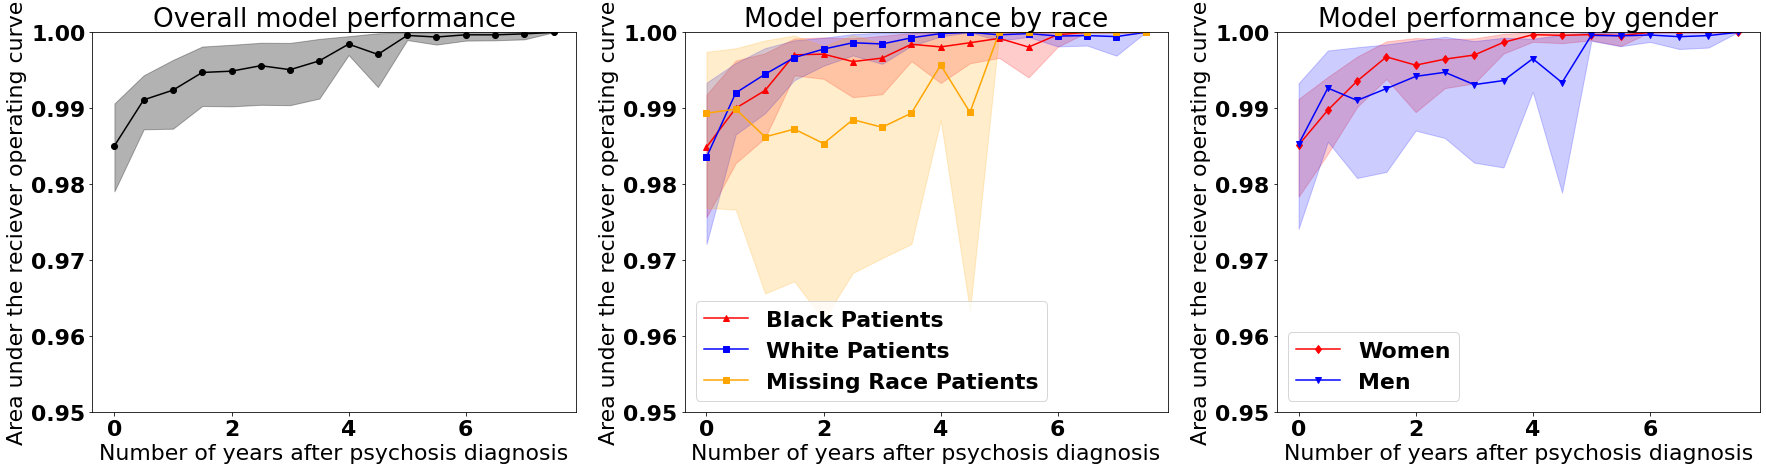

In [24]:
font = {'weight' : 'bold',
        'size'   : 22}


plt.figure(figsize=(25, 7))
matplotlib.rc('font', **font)

cutoff_ind = 16
## Forwards iterations, by time
n_years = iterations[0:cutoff_ind]

auroc = np.asarray(auroc[0:cutoff_ind])
auroc_ci = np.asarray(auroc_ci[0:cutoff_ind])

plt.subplot(1,3,1)
# all patients
plt.plot(n_years, auroc, color = 'black', marker = 'o')
plt.fill_between(n_years, np.abs(auroc_ci.T)[0,:], np.abs(auroc_ci.T)[1,:], color='black', alpha=0.3)

plt.xlabel('Number of years after psychosis diagnosis')
plt.ylabel('Area under the reciever operating curve')
plt.title('Overall model performance')
plt.ylim([0.95, 1])


plt.subplot(1,3,2)
## Black Patients
auroc_b = np.asarray(auroc_b[0:cutoff_ind])
auroc_ci_b = np.asarray(auroc_ci_b[0:cutoff_ind])
plt.plot(n_years, auroc_b, label = 'Black Patients', color = 'red', marker = '^')
plt.fill_between(n_years, np.abs(auroc_ci_b.T)[0,:], np.abs(auroc_ci_b.T)[1,:], color='red', alpha=0.2)

## White Patients
auroc_w = np.asarray(auroc_w[0:cutoff_ind])
auroc_ci_w = np.asarray(auroc_ci_w[0:cutoff_ind])
plt.plot(n_years, auroc_w, label = 'White Patients', color = 'blue', marker = 's')
plt.fill_between(n_years, np.abs(auroc_ci_w.T)[0,:], np.abs(auroc_ci_w.T)[1,:], color='blue', alpha=0.2)

## Missing Patients
auroc_missing = np.asarray(auroc_missing[0:cutoff_ind])
auroc_ci_missing = np.asarray(auroc_ci_missing[0:cutoff_ind])
plt.plot(n_years, auroc_missing, label = 'Missing Race Patients', color = 'orange', marker = 's')
plt.fill_between(n_years, np.abs(auroc_ci_missing.T)[0,:], np.abs(auroc_ci_missing.T)[1,:], color='orange', alpha=0.2)

plt.xlabel('Number of years after psychosis diagnosis')
plt.ylabel('Area under the reciever operating curve')
plt.title('Model performance by race')
plt.ylim([0.95, 1])
plt.legend()

plt.subplot(1,3,3)
## Female Patients
auroc_f = np.asarray(auroc_f[0:cutoff_ind])
auroc_ci_f = np.asarray(auroc_ci_f[0:cutoff_ind])
plt.plot(n_years, auroc_f, label = 'Women', color = 'red', marker = 'd')
plt.fill_between(n_years, np.abs(auroc_ci_f.T)[0,:], np.abs(auroc_ci_f.T)[1,:], color='red', alpha=0.2)

## Male Patients
auroc_m = np.asarray(auroc_m[0:cutoff_ind])
auroc_ci_m = np.asarray(auroc_ci_m[0:cutoff_ind])
plt.plot(n_years, auroc_m, label = 'Men', color = 'blue', marker = 'v')
plt.fill_between(n_years, np.abs(auroc_ci_m.T)[0,:], np.abs(auroc_ci_m.T)[1,:], color='blue', alpha=0.2)

plt.xlabel('Number of years after psychosis diagnosis')
plt.title('Model performance by gender')
plt.ylabel('Area under the reciever operating curve')
plt.ylim([0.95, 1])
plt.legend()
plt.tight_layout()
plt.savefig('results/xgboost_time_performance_auroc.pdf', dpi=300)
plt.show()